# Statistical Techniques, 5 May 2023
## Homework 2
-----
## Buguev Anton, BS19-RO-01

## Task 1

### Subtask 4

#### Define Beta and Gamma functions

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def gamma_func(n):
    return np.math.factorial(n-1)
def beta_func(theta, alpha=1, beta=4):
    return gamma_func(alpha+beta)/(gamma_func(alpha)*gamma_func(beta))*theta**(alpha-1)*(1-theta)**(beta-1)

#### Plot prior and posterior deistributions

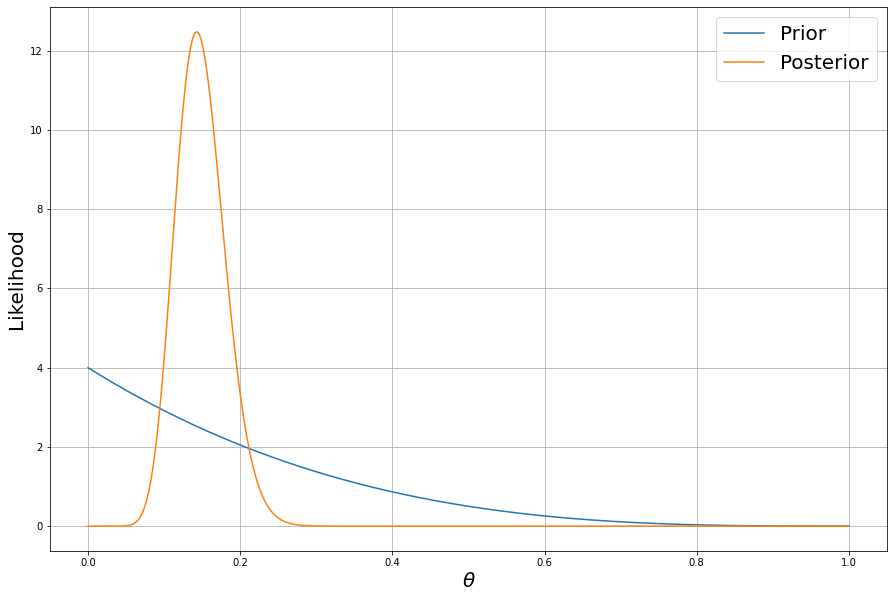

In [36]:
theta_arr = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(theta_arr, beta_func(theta_arr), label="Prior")
ax.plot(theta_arr, beta_func(theta_arr, alpha=18, beta=103), label="Posterior")

ax.set_xlabel(r"$\theta$", fontsize=20)
ax.set_ylabel(r"Likelihood", fontsize=20)
ax.grid()
ax.legend(fontsize=20)

### Subtask 5

#### Fompute CDF to find probability of $\theta<0.1$

In [37]:
from scipy.stats import beta

print(f"Probability is {beta.cdf(0.1, 18, 103)}.")

Probability is 0.05309437699304261.


### Subtask 6

#### Fompute PPF to find the central 95% posterior credible interval

In [38]:
left_bound = beta.ppf((1-0.95)/2, 18, 103)
print(f"Left boundary of interval is {left_bound}.")

Left boundary of interval is 0.09138957252823.


In [39]:
right_bound = beta.ppf(0.95+(1-0.95)/2, 18, 103)
print(f"Right boundary of interval is {right_bound}.")


Right boundary of interval is 0.21710689824337648.


In [40]:
print(f"The final interval is {(left_bound, right_bound)}.")

The final interval is (0.09138957252823, 0.21710689824337648).


### Task 2

#### Import data, sort cities by population and take first 30 cities

In [41]:
import pandas as pd
import numpy as np
import random
import json
import matplotlib.pyplot as plt
import time

df = pd.read_csv("city.csv")
most_pop_cities = df.sort_values(by=['population'], ascending=False)[:30]
most_pop_cities.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
509,г Москва,101000.0,Россия,Центральный,г,Москва,NaN,NaN,NaN,NaN,...,1,0,45000000000,45000000,7700,UTC+3,55.754047,37.620405,11514330,1147
786,г Санкт-Петербург,190000.0,Россия,Северо-Западный,г,Санкт-Петербург,NaN,NaN,NaN,NaN,...,1,0,40000000000,40000000,7800,UTC+3,59.939131,30.315900,4848742,1703
647,г Новосибирск,630000.0,Россия,Сибирский,обл,Новосибирская,NaN,NaN,г,Новосибирск,...,4,2,50401000000,50701000001,5400,UTC+7,55.028191,82.921149,1498921,1893
832,г Екатеринбург,620000.0,Россия,Уральский,обл,Свердловская,NaN,NaN,г,Екатеринбург,...,4,2,65401000000,65701000001,6600,UTC+5,56.838522,60.605491,1377738,1723
619,г Нижний Новгород,603000.0,Россия,Приволжский,обл,Нижегородская,NaN,NaN,г,Нижний Новгород,...,4,2,22401000000,22701000001,5200,UTC+3,56.324063,44.005391,1250615,1221


#### Preprocess data from table

In [42]:
# Store the city name
cities = most_pop_cities["address"].tolist()
cities = [city.split("г ")[-1] for city in cities]

# Store cities longitude and latitude
cities_long = most_pop_cities["geo_lon"].tolist()
cities_lat = most_pop_cities["geo_lat"].tolist()

# Create dictionary with city as key and its coordinates as value
cities_dict = {city: [cities_long[i], cities_lat[i]]
               for i, city in enumerate(cities)}


#### Functions to compute the distance between two cities and the distance of the whole route.

We cannot find the distance between cities using euclidean distance, because the Earth has curvature. Hence, the following equation comes in hand:
$$L=d\cdot R$$
where
$$
\begin{cases}
    d = \arccos{(\sin{\phi_1}\cdot\sin{\phi_2}+\cos{\phi_1}\cdot\cos{phi_2}\cdot\cos{(\lambda_1-\lambda_2)})},\\
    R = 6371km\text{ - Earth radius}
\end{cases}
$$
where
$$\phi_1, \phi_2, \lambda_1, \lambda_2\text{ - latitude and longitude of city$_1$ and city$_2$ respectively.}$$

In [43]:
def compute_distance(lon1, lat1, lon2, lat2):
    R = 6371
    # Convert coordinates into radians from degrees
    lat1, lon1, lat2, lon2 = np.deg2rad((lat1, lon1, lat2, lon2))
    d = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1)
                  * np.cos(lat2)*np.cos(lon1-lon2))
    return d * R


def total_distance(coords):
    path_len = 0
    for i in range(len(coords)-1):
        # Compute distance from he curren city o the next one
        path_len += compute_distance(coords[i][0],   coords[i][1],
                                     coords[i+1][0], coords[i+1][1])
    return path_len


#### Import data with coordinates of Russia boundaries

In [44]:
russia_data = json.load(open('russia.json'))[0]['geojson']['coordinates']
russia_coord = []
for i in russia_data:
    russia_coord = russia_coord + i[0]

# Since some part of Russia is located in west semisphere, for proper display we need to convert such coordinates
# simply project the longitude value on the other side of the sphere, i.e. add 360 to the degree value
for i in range(len(russia_coord)):
    x = russia_coord[i][0]
    if x < 0:
        russia_coord[i][0] += 360
russia_coord = np.array(russia_coord)


#### Function to plot the path

In [45]:
def plot_path(coords, length, rate, time_taken):
    # Take the last path of all computed routes and store cities coordinates in the order of the path
    x, y = coords[:,0].tolist(), coords[:, 1].tolist()
    _, ax = plt.subplots(figsize=(30, 15))

    # Plot Russia boundaries
    ax.plot(russia_coord[:, 0], russia_coord[:, 1],
            'o', color='green', markersize=0.5)
    # Set title with information about computed path length, cooling rate used in computation and time taken to compute the path
    ax.set_title(
        f"Computed path: distance: {length} km, rate: {rate}, time taken: {round(time_taken, 2)}s", fontsize=20)
    ax.set_xlabel("Longitude", fontsize=20)
    ax.set_ylabel("Latitude", fontsize=20)
    ax.plot(x, y) # Path
    ax.plot(x[:-1], y[:-1], 'o', c='orange') # Cities
    # Sign every dot on the plot with corresponding city name
    for _, city in enumerate(cities):
        ax.annotate(city, cities_dict[city], fontsize=12)


#### Create initial random path

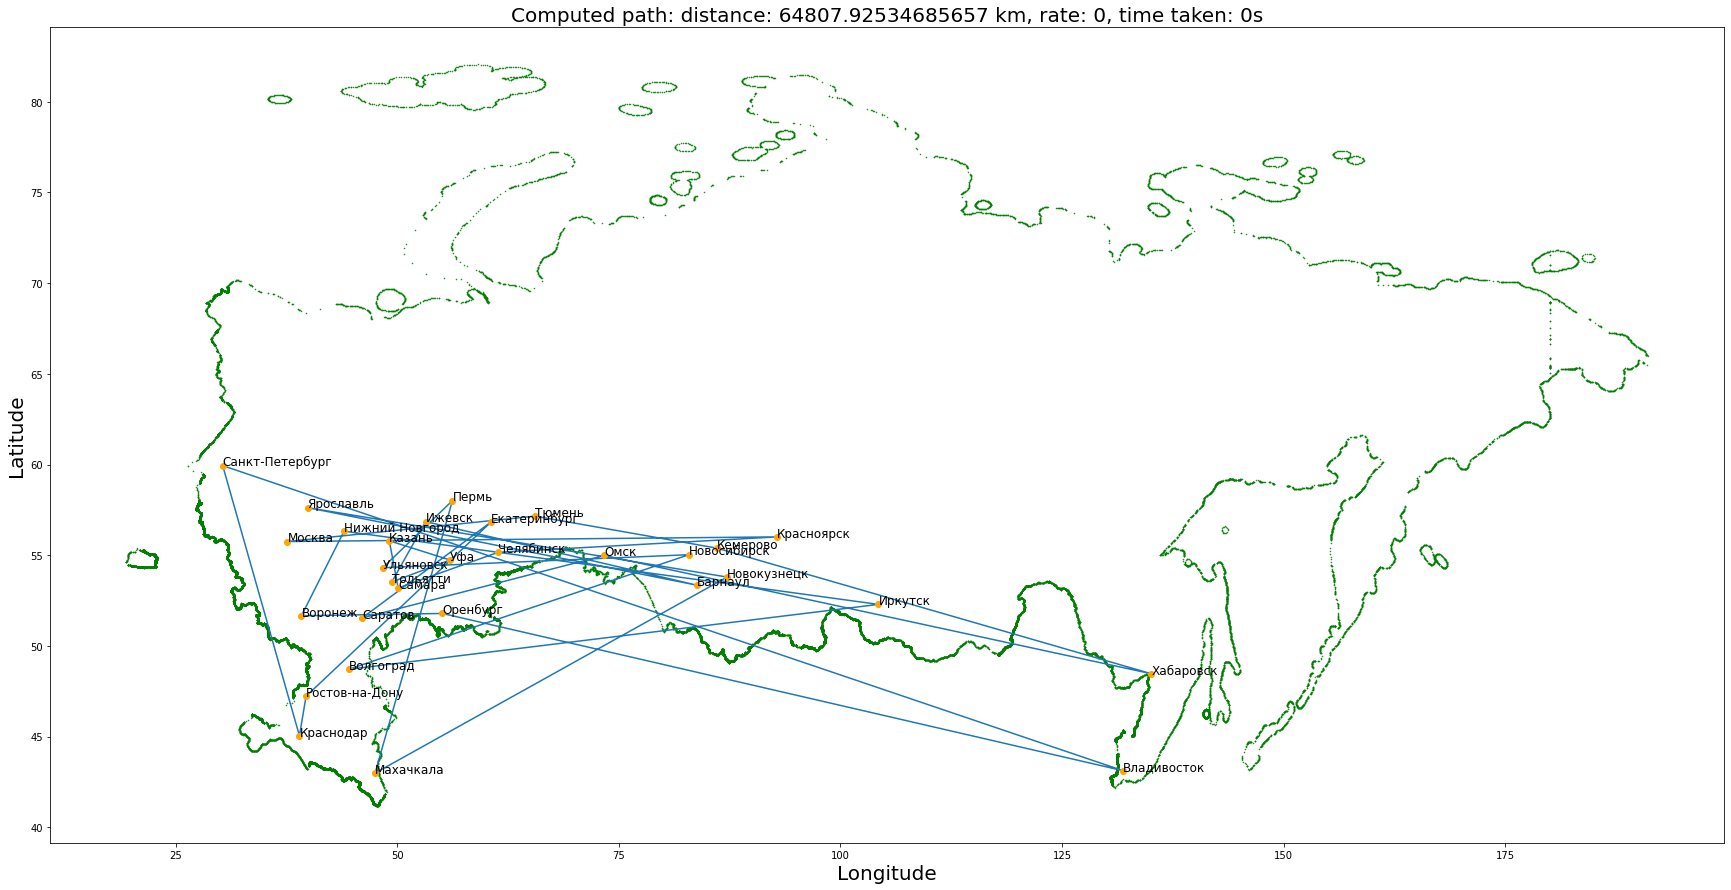

In [46]:
# We need only coordinates of the cities for computation, so let us omit the city names and keep only coordinates
init_coords = list(cities_dict.values())
# Shuffle cities order
random.shuffle(init_coords)
# Since salesman must return to the initial city, we need to add it as last element of the path
init_coords.append(init_coords[0])

# Longitudes and latitueds of initial random path
init_long = np.array(init_coords)[:, 0]
init_lat = np.array(init_coords)[:, 1]

# Plot initial random path with computed distance
plot_path(np.array(init_coords), total_distance(init_coords), 0, 0)

#### Implement Simulated Annealing algorithm

In [47]:
def simulated_annealing(init_coords, temp, fin_temp, rate):
    # Set the initial path and its length as current path and current path length
    cur_coords = init_coords[:]
    cur_path_len = total_distance(cur_coords)

    # For the animation we need to save all intermediate steps
    # so let us store all routes and their length
    all_coords = [np.array(cur_coords)]
    all_lengths = [cur_path_len]
    
    # Also for the information let us track execution time
    time_arr = [time.time()]
    
    # Simulate the annealing until the process is cooled down
    while temp > fin_temp:
        # Print curren path length
        print(f"Path length: {cur_path_len} km", end=' \r')

        # Copy path to switch two random sities
        # Since the last city in the path is the same as first, we need to ignore it to switch correctly
        upd_coords = cur_coords[:-1].copy()
        idx1, idx2 = random.sample(range(len(cities)), 2)
        upd_coords[idx1], upd_coords[idx2] = upd_coords[idx2], upd_coords[idx1]
        
        # Add the first city in the end of the route to compute acceptance ratio
        upd_coords.append(upd_coords[0])
        # Compute new path length
        upd_path_len = total_distance(upd_coords)

        # Compute difference of paths lengths
        diff = upd_path_len - cur_path_len
        alpha = np.exp(-diff/temp)
        u = random.random()
        # If random u from uniform distribution is smaller than acceptance ratio,
        # we update the current path
        if u <= alpha:
            cur_coords = upd_coords.copy()
            cur_path_len = upd_path_len

        # Decrease temperature
        temp = temp * rate

        # Add path to the list for later animation
        all_coords.append(np.array(cur_coords))
        all_lengths.append(cur_path_len)
        time_arr.append(time.time())
    
    # To actually compute execution time, we need to subtract initial time from all timespteps
    time_arr = np.array(time_arr)
    time_arr -= time_arr[0]

    # Return all computed routes, their lengths and time taken at each step
    return all_coords, all_lengths, time_arr


#### Use simulated annealing with different cooling ratio

In [48]:
T = 10000 # initial temperature
fin_T = 1 # final temperature
fast_rate = 0.8 # fast cooling ratio
mid_rate = 0.9 # medium cooling ratio
slow_rate = 0.99 # slow cooling ratio


##### Fast SA

C:\Users\bugue\AppData\Local\Temp/ipykernel_22748/30425039.py:32: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(-diff/temp)


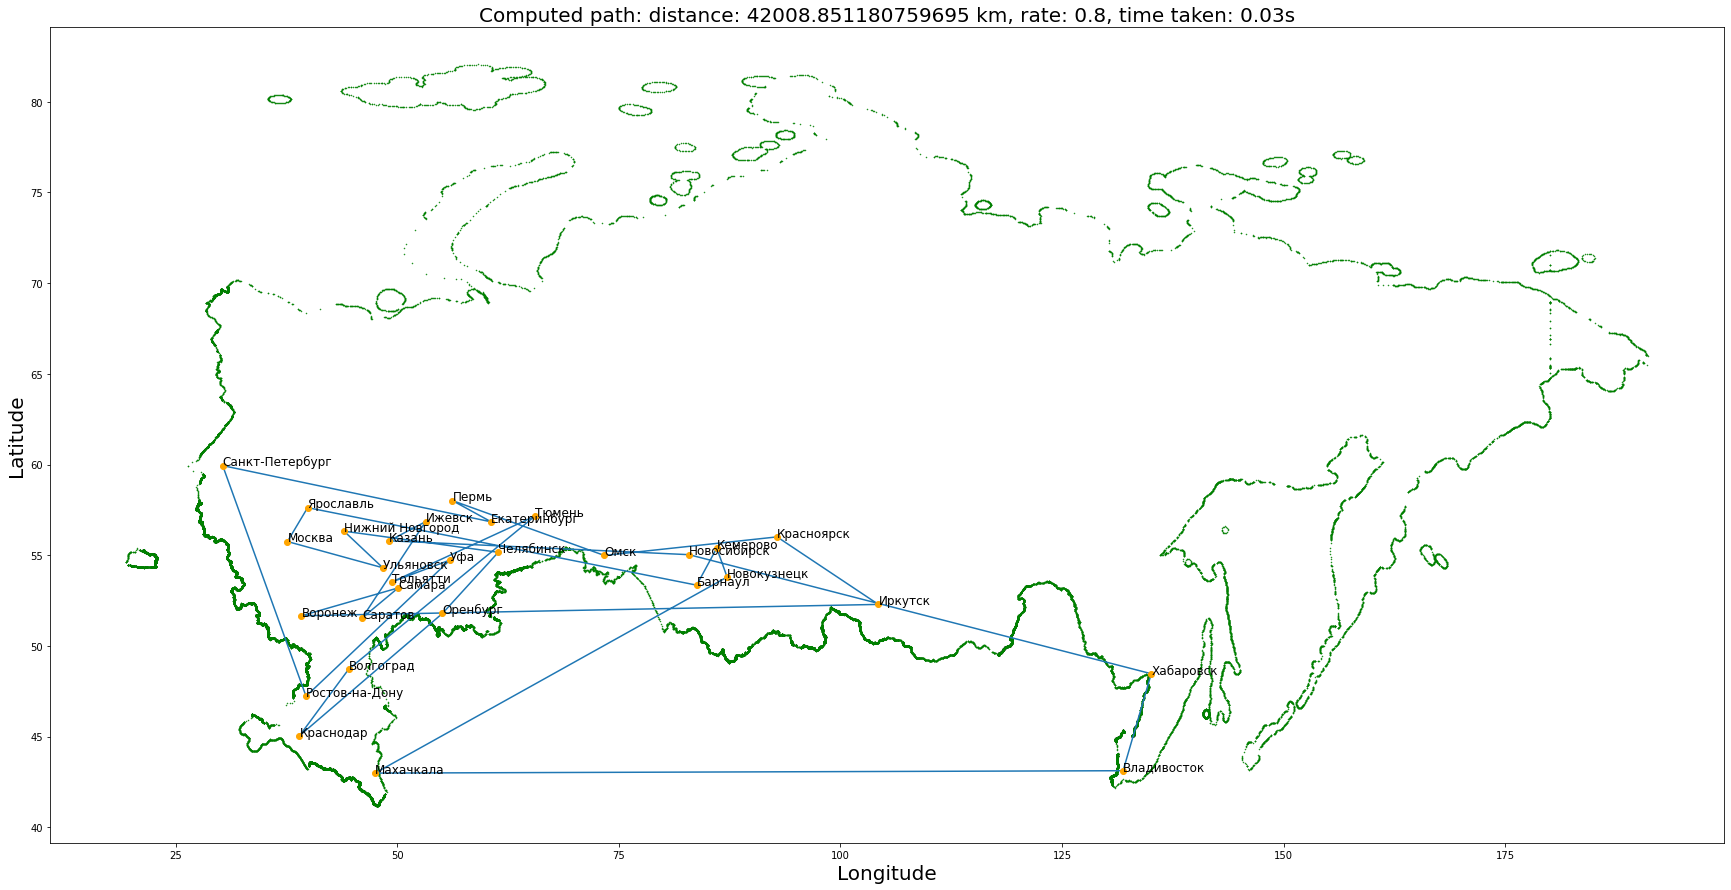

In [49]:
fast_coords, fast_lengths, fast_time = simulated_annealing(init_coords, temp=T, fin_temp=fin_T, rate=fast_rate)

plot_path(fast_coords[-1], fast_lengths[-1], fast_rate, fast_time[-1])

##### Medium SA

C:\Users\bugue\AppData\Local\Temp/ipykernel_22748/30425039.py:32: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(-diff/temp)


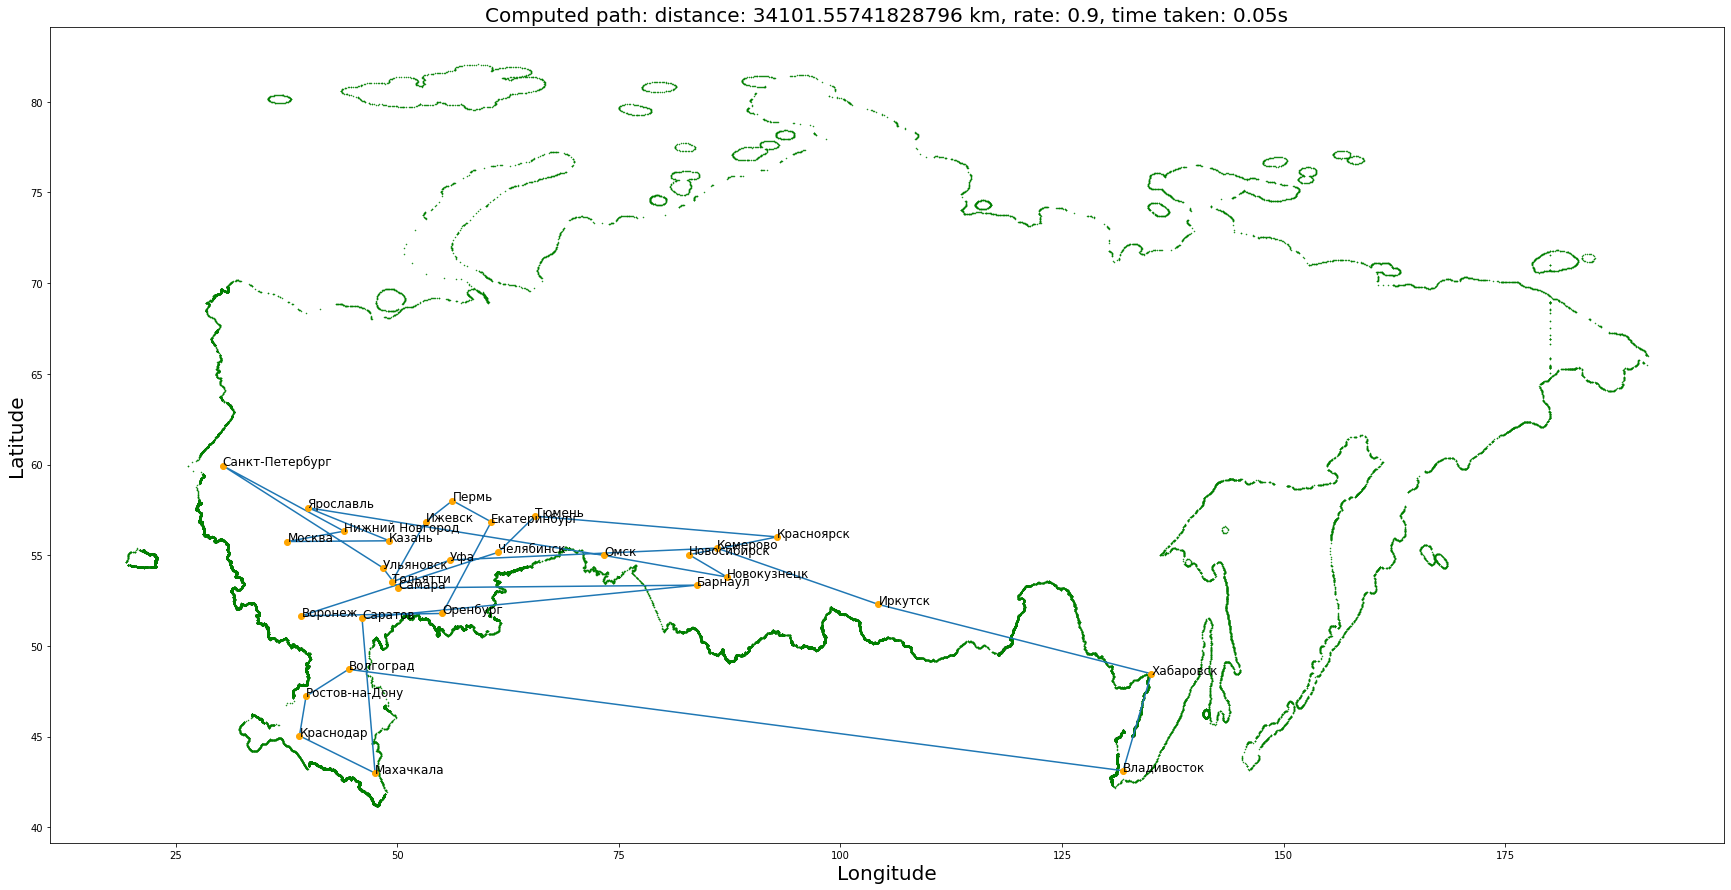

In [50]:
mid_coords, mid_lengths, mid_time = simulated_annealing(init_coords, temp=T, fin_temp=fin_T, rate=mid_rate)
plot_path(mid_coords[-1], mid_lengths[-1], mid_rate, mid_time[-1])


##### Slow SA

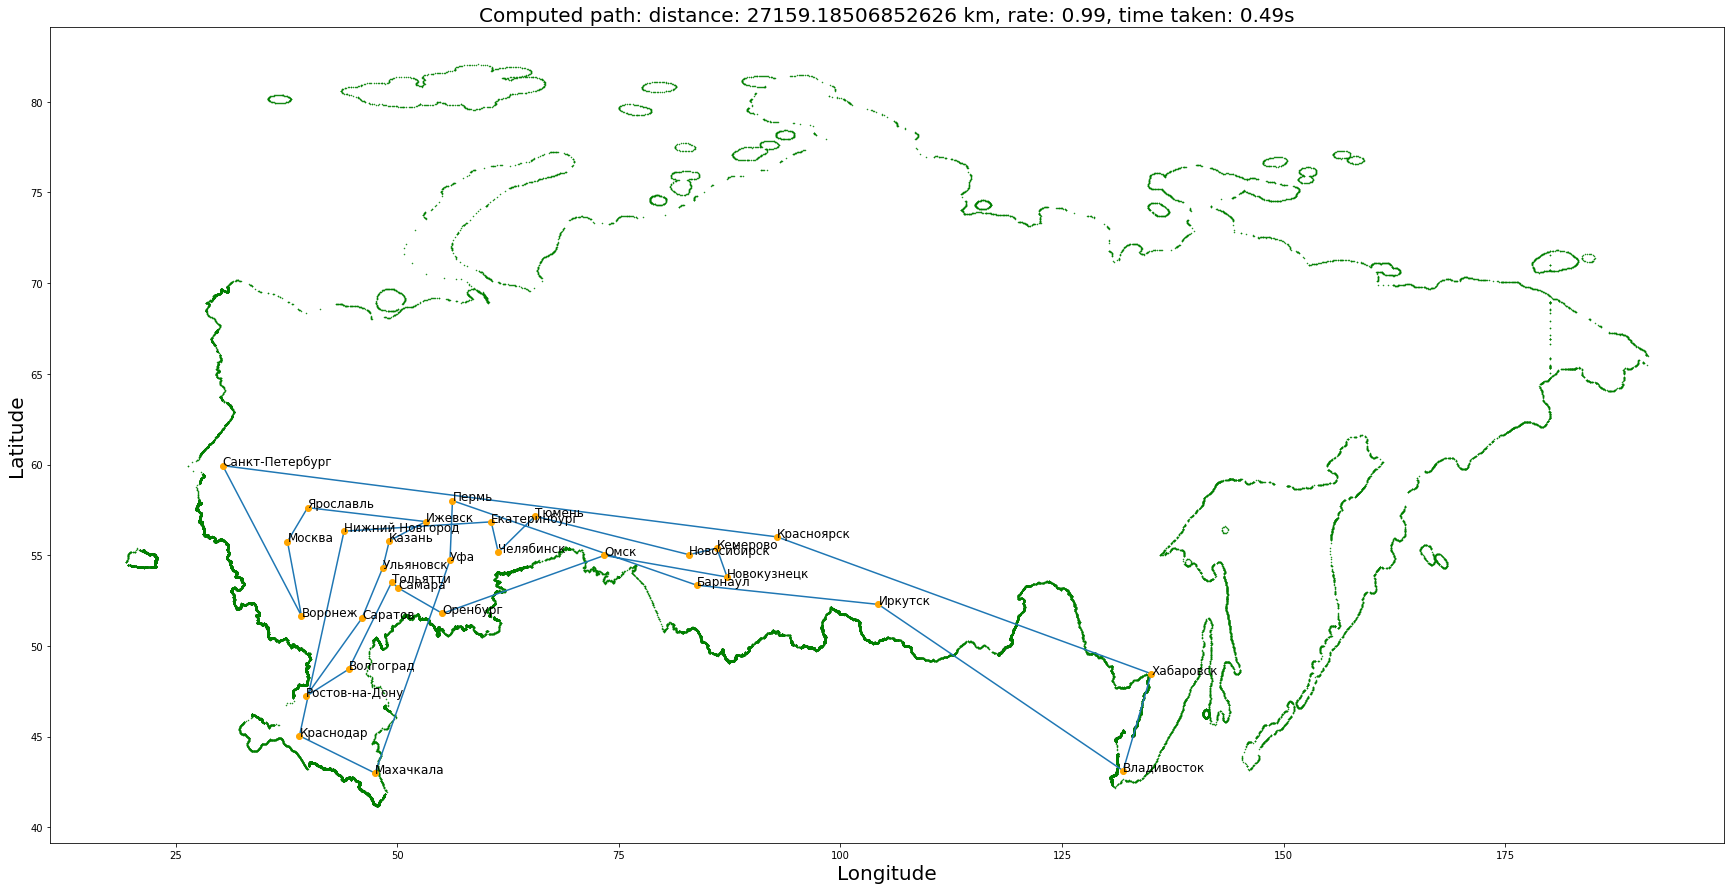

In [51]:
slow_coords, slow_lengths, slow_time = simulated_annealing(init_coords, temp=T, fin_temp=fin_T, rate=slow_rate)
plot_path(slow_coords[-1], slow_lengths[-1], slow_rate, slow_time[-1])


#### Display the speed of convergence

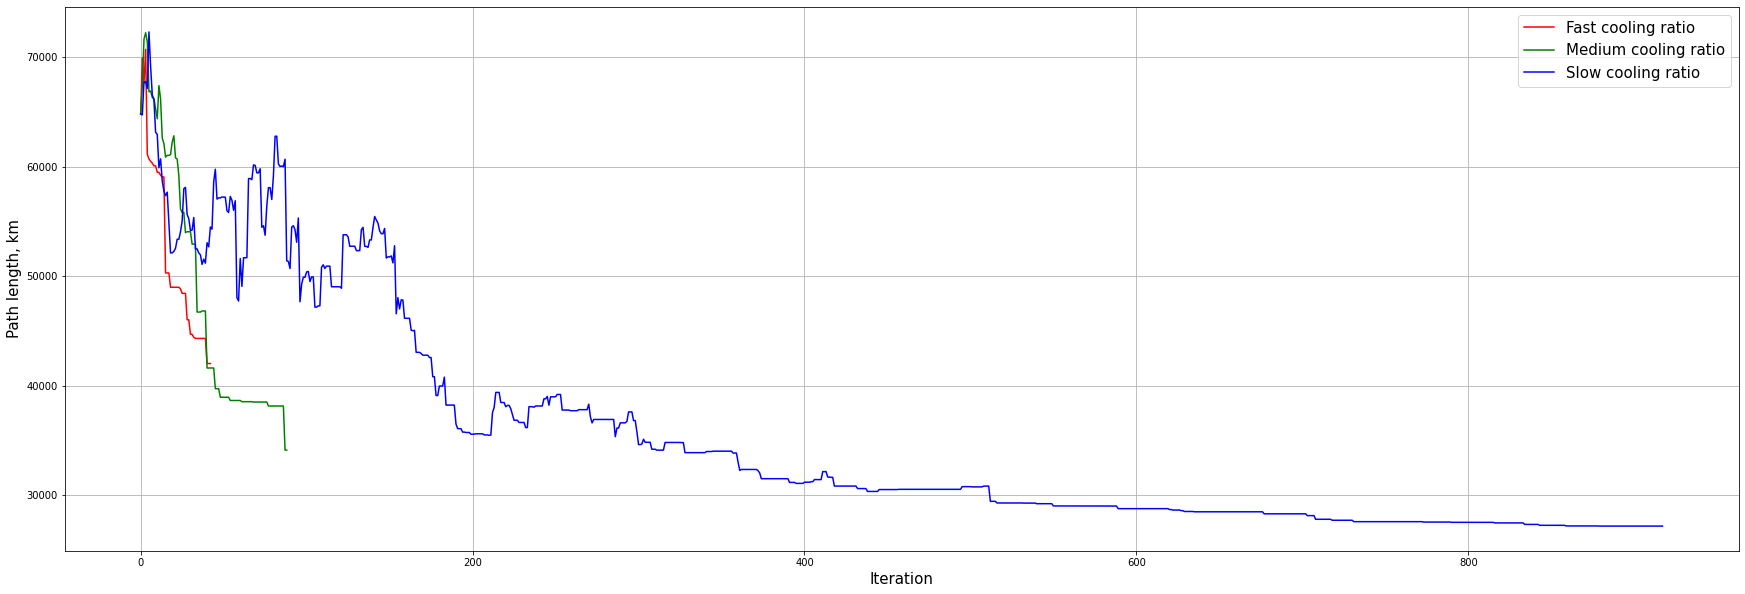

In [52]:
_, ax = plt.subplots(figsize=(30, 10))

ax.grid()
ax.plot(range(fast_time.shape[0]), fast_lengths, c="red", label="Fast cooling ratio")
ax.plot(range(mid_time.shape[0]), mid_lengths, c="green", label="Medium cooling ratio")
ax.plot(range(slow_time.shape[0]), slow_lengths, c="blue", label="Slow cooling ratio")
ax.set_xlabel("Iteration", fontsize=15)
ax.set_ylabel("Path length, km", fontsize=15)

ax.legend(fontsize=15)


#### Create and save animation

In [53]:
from matplotlib.animation import FuncAnimation, PillowWriter
from functools import partial

# Plot initial data, in our case it is country boundaries and cities
def init(path_plot):
    ax.plot(russia_coord[:, 0], russia_coord[:, 1],
            'o', color='green', markersize=0.5)
    ax.set_xlabel("Longitude", fontsize=20)
    ax.set_ylabel("Latitude", fontsize=20)
    ax.plot(cities_long, cities_lat, 'o', c='orange')
    for i, txt in enumerate(cities):
        ax.annotate(txt, (cities_long[i], cities_lat[i]), fontsize=10)
    return path_plot,

# Animate results
def animation_frame(i, path_plot, coords, time_arr):
    # For each frame draw corresponding computed path
    path_plot.set_data(coords[i][:,0], coords[i][:,1])
    ax.set_title(
        f"Computed path: distance: {round(total_distance(coords[i]), 2)} km, time taken: {round(time_arr[i], 2)}s", fontsize=20)
    return path_plot,

In [54]:
print("Start saving animation animation")
fps = 15
# Fast animation
fig, ax = plt.subplots(figsize=(30, 15))
fast_path_plot, = ax.plot([], [])
animation = FuncAnimation(fig, partial(animation_frame, path_plot=fast_path_plot, coords=fast_coords, time_arr=fast_time),
                          frames=len(fast_coords), init_func=partial(init, path_plot=fast_path_plot), blit=True)
savegif = PillowWriter(fps=fps)
animation.save("SA_fast.gif", writer=savegif)
plt.close()
print("Saved fast animation")

# Medium animation
fig, ax = plt.subplots(figsize=(30, 15))
mid_path_plot, = ax.plot([], [])
animation = FuncAnimation(fig, partial(animation_frame, path_plot=mid_path_plot, coords=mid_coords, time_arr=mid_time),
                          frames=len(mid_coords), init_func=partial(init, path_plot=mid_path_plot), blit=True)
savegif = PillowWriter(fps=fps)
animation.save("SA_middle.gif", writer=savegif)
plt.close()
print("Saved medium animation")

# Slow animation
fig, ax = plt.subplots(figsize=(30, 15))
slow_path_plot, = ax.plot([], [])
animation = FuncAnimation(fig, partial(animation_frame, path_plot=slow_path_plot, coords=slow_coords, time_arr=slow_time),
                          frames=len(slow_coords), init_func=partial(init, path_plot=slow_path_plot), blit=True)
savegif = PillowWriter(fps=fps)
animation.save("SA_slow.gif", writer=savegif)
plt.close()
print("Saved slow animation")